<a href="https://colab.research.google.com/github/Vernalhav/image_processing_project/blob/main/stitcher.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import math
from scipy import ndimage
from skimage import transform, io

import os

In [ ]:
def downscale(img, factor):
    width = int(img.shape[1] * factor)
    height = int(img.shape[0] * factor)
    dim = (width, height)
    
    resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
    return resized

In [ ]:
def load_dataset_instance(num, return_as_matrix=False, downscale_factor=1):
    imgs = []
    for i in range(5):
        if return_as_matrix: imgs.append([])

        for j in range(5):
            img = cv2.imread(f'/drive/Shareddrives/PDI/Dataset/{num}/seq{num}_{i+1}_{j+1}.jpg')
            if return_as_matrix: imgs[-1].append(img)
            else: imgs.append(img)
    
    return imgs

In [ ]:
imgs = []

def main():
    global imgs
    
    if not os.path.exists('/drive'):
        from google.colab import drive
        drive.mount('/drive')
    
    imgs = load_dataset_instance(1, True)

In [ ]:
if __name__ == '__main__':
    main()

## Identificação do grid

In [ ]:
from functools import reduce
import operator
import math

def sort_clockwise(points):
    '''
    Returns points sorted in clockwise order starting from the bottom left corner.
    Because image coordinates are flipped, this returns the four corners of the
    rectangle in the following order:
        TOP_LEFT, BOTTOM_LEFT, BOTTOM_RIGHT, TOP_RIGHT
    '''
    center = tuple(map(operator.truediv, reduce(lambda x, y: map(operator.add, x, y), points), [len(points)] * 2))
    return sorted(points, key=lambda coord: (-135 - math.degrees(math.atan2(*tuple(map(operator.sub, coord, center))[::-1]))) % 360)

In [ ]:
from matplotlib.patches import Circle

def view_corners(image, coords, blobSize=300, subplot=(1,1,1)):
    ax = plt.subplot(subplot[0], subplot[1], subplot[2])
    ax.imshow(image)
    TOP_RIGHT  = (1, 0, 0)
    TOP_LEFT   = (0, 1, 0)
    BOT_LEFT   = (0, 0, 1)
    BOT_RIGHT  = (1, 1, 0)

    topLeftA, botLeftA, botRightA, topRightA = coords
    ax.add_patch(Circle(botLeftA, blobSize, color=BOT_LEFT))
    ax.add_patch(Circle(botRightA, blobSize, color=BOT_RIGHT))
    ax.add_patch(Circle(topLeftA, blobSize, color=TOP_LEFT))
    ax.add_patch(Circle(topRightA, blobSize, color=TOP_RIGHT))

In [ ]:
def show_img(img, subplot, cmap='gray'):
    plt.subplot(subplot[0], subplot[1], subplot[2])
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img, cmap=cmap)

def debug_central_box(original, grid, morphed, opened, skeleton, flood, coords):
    plt.figure(figsize=(20,20))
    show_img(grid, (2, 3, 1))
    show_img(morphed, (2, 3, 2))
    show_img(opened, (2, 3, 3))
    show_img(skeleton, (2, 3, 4))
    show_img(flood, (2, 3, 5))
    view_corners(original, coords, 20, (2, 3, 6))
    plt.tight_layout()

In [ ]:
from skimage.morphology import skeletonize

def find_central_box(img, showImage=False, scale_factor=1):

    _, grid = cv2.threshold(img, 210, 255, cv2.THRESH_BINARY)

    grid = cv2.cvtColor(grid, cv2.COLOR_BGR2GRAY)

    kernel = cv2.getStructuringElement(cv2.MORPH_DILATE, (3,3))
    morphed = cv2.morphologyEx(grid, cv2.MORPH_DILATE, kernel, iterations=int(50*(scale_factor)))
    kernel = cv2.getStructuringElement(cv2.MORPH_OPEN, (5,5))
    opened = cv2.morphologyEx(morphed, cv2.MORPH_OPEN, kernel, iterations=int(35*(scale_factor)))
    opened[opened > 0] = 1
    opened[opened <= 0] = 0

    # perform skeletonization
    skeleton = skeletonize(opened).astype(np.uint8)

    # fill the central region
    flood = cv2.floodFill(skeleton, None, (int(img.shape[0]/2), int(img.shape[1]/2)), newVal = (255,255,255))[1]
    _, flood = cv2.threshold(flood, 210, 255, cv2.THRESH_BINARY)

    cnts, _ = cv2.findContours(flood, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if len(cnts) > 1:
        print("WARNING: Mais de um contorno encontrado.")

    rect = cv2.minAreaRect(cnts[0])
    box = cv2.boxPoints(rect)
    box = sort_clockwise(np.int0(box))

    if showImage:
        debug_central_box(img, grid, morphed, opened, skeleton, flood, box)

    return box

## Reconstrução do grid

In [ ]:
from enum import Enum, auto

class MatchMode(Enum):
    Horizontal = auto()
    Vertical = auto()


def get_transform(corner_coordsA, corner_coordsB, direction=MatchMode.Horizontal, return_matrix=False):
    '''
    Returns the transformation matrix that takes the relevant points
    in corner_coordsB and maps them to the relevant points in corner_coordsA:
        A = Matrix * B

    If return_matrix is false, returns the skimage Transform object that contains
    the rotation and translation parameters
    '''
    topLeftA, botLeftA, botRightA, topRightA = corner_coordsA
    topLeftB, botLeftB, botRightB, topRightB = corner_coordsB

    source, dest = None, None
    if direction == MatchMode.Horizontal:
        source = np.array([topLeftB, botLeftB])
        dest = np.array([topRightA, botRightA])
    
    if direction == MatchMode.Vertical:
        source = np.array([topLeftB, topRightB])
        dest = np.array([botLeftA, botRightA])

    M = transform.estimate_transform('euclidean', source, dest)
    
    if return_matrix:
        return M.params
    
    return M

In [ ]:
class _TileRelativeTransforms():
    '''
    Returns transformation parameters between this cell and the adjacent
    ones (left or up). None means that there are no adjacent cells in
    that direction.
    global_t corresponds to the transformation parameters between this cell
    and the (0, 0)-th image.
    '''
    def __init__(self, left=None, up=None, global_t=None):
        self.left = up
        self.up = up
        self.global_t = global_t


# Should not be used directly. Use stitch_grid instead
class _Stitcher:
    def __init__(self, img_grid, scale_factor=1):
        self.n = len(img_grid)
        self.m = len(img_grid[0])
        self.img_grid = img_grid
        self.scale_factor = scale_factor
        print(f'Created stitcher with grid size ({self.n}, {self.m})')
        # Matrix containing the [i, j]-th image's corner coordinates
        self.corner_coords = None
        
        # Matrix containing the [i, j]-th image's transforms to its
        # adjacent (left, up) cells and its global (relative to (0, 0))
        # transform.
        self.transforms = None
    

    def compute_corner_coords(self):
        corner_coords = []
        
        for i in range(self.n):
            corner_coords.append([])
            for j in range(self.m):
                print(f'Finding corners of image ({i}, {j})...', end=' ')
                coords = find_central_box(self.img_grid[i][j], False, self.scale_factor)
                coords = list(map(lambda x : x/self.scale_factor, coords))
                corner_coords[i].append(coords)
                print('done!')

        self.corner_coords = corner_coords
        return corner_coords
    
    
    def compute_relative_transforms(self, corner_coords=None):
        if corner_coords is None:
            corner_coords = self.corner_coords

        relative_transforms = []
        for i in range(self.n):
            relative_transforms.append([])

            for j in range(self.m):
                curTransforms = _TileRelativeTransforms()
                
                if i > 0:
                    curTransforms.up = get_transform(corner_coords[i-1][j], corner_coords[i][j], MatchMode.Vertical, return_matrix=True)
                if j > 0:
                    curTransforms.left = get_transform(corner_coords[i][j-1], corner_coords[i][j], MatchMode.Horizontal, return_matrix=True)

                relative_transforms[i].append(curTransforms)
        
        self.transforms = relative_transforms
        return relative_transforms
    

    def compute_global_transforms(self, transforms=None):
        '''
        Computes the global transform of each image in relation
        to the (0, 0)-th image
        '''
        
        if transforms is None:
            transforms = self.transforms
        
        transforms[0][0].global_t = np.eye(3)  # First image has no transform relative to itself

        for i in range(1, self.n):
            transforms[i][0].global_t = np.dot(transforms[i-1][0].global_t, transforms[i][0].up)

        for j in range(1, self.m):
            transforms[0][j].global_t = np.dot(transforms[0][j-1].global_t, transforms[0][j].left)

        t = 0.5     # Weight given to the up transform 
        for i in range(1, self.n):
            for j in range(1, self.m):
                up_transform = np.dot(transforms[i-1][j].global_t, transforms[i][j].up)
                left_transform = np.dot(transforms[i][j-1].global_t, transforms[i][j].left)
                transforms[i][j].global_t = (t * up_transform + (1 - t) * left_transform)   # "TEM QUE TESTAR, MOFIU!!" - Mãe
    
        self.transforms = transforms
        return transforms
    
    def get_stitched_image(self, transforms=None):
        if transforms is None:
            transforms = self.transforms

        img_dims = self.img_grid[0][0].shape
        output_dims = (self.n * img_dims[0], self.m * img_dims[1], img_dims[2])
        output_img = np.zeros(output_dims, dtype=np.uint8)

        for i in range(self.n):
            for j in range(self.m):
                print(f'Stitching image ({i}, {j})...', end=' ')
                cv2.warpAffine(img_grid[i][j], transforms[i][j].global_t[:2,:],
                               (output_dims[1], output_dims[0]),
                               dst=output_img, borderMode=cv2.BORDER_TRANSPARENT)
                print('done!')

        return output_img

    def stitch(self):
        self.compute_corner_coords()
        self.compute_relative_transforms()
        self.compute_global_transforms()
        return self.get_stitched_image()

In [ ]:
# Optional stitcher wtapper function:
# takes in the image grid and returns stitched image
def stitch_grid(img_grid, scale_factor=1):
    stitcher = _Stitcher(img_grid, scale_factor=scale_factor)
    return stitcher.stitch()

## Exemplos

In [ ]:
img_grid = load_dataset_instance(1, return_as_matrix=True)

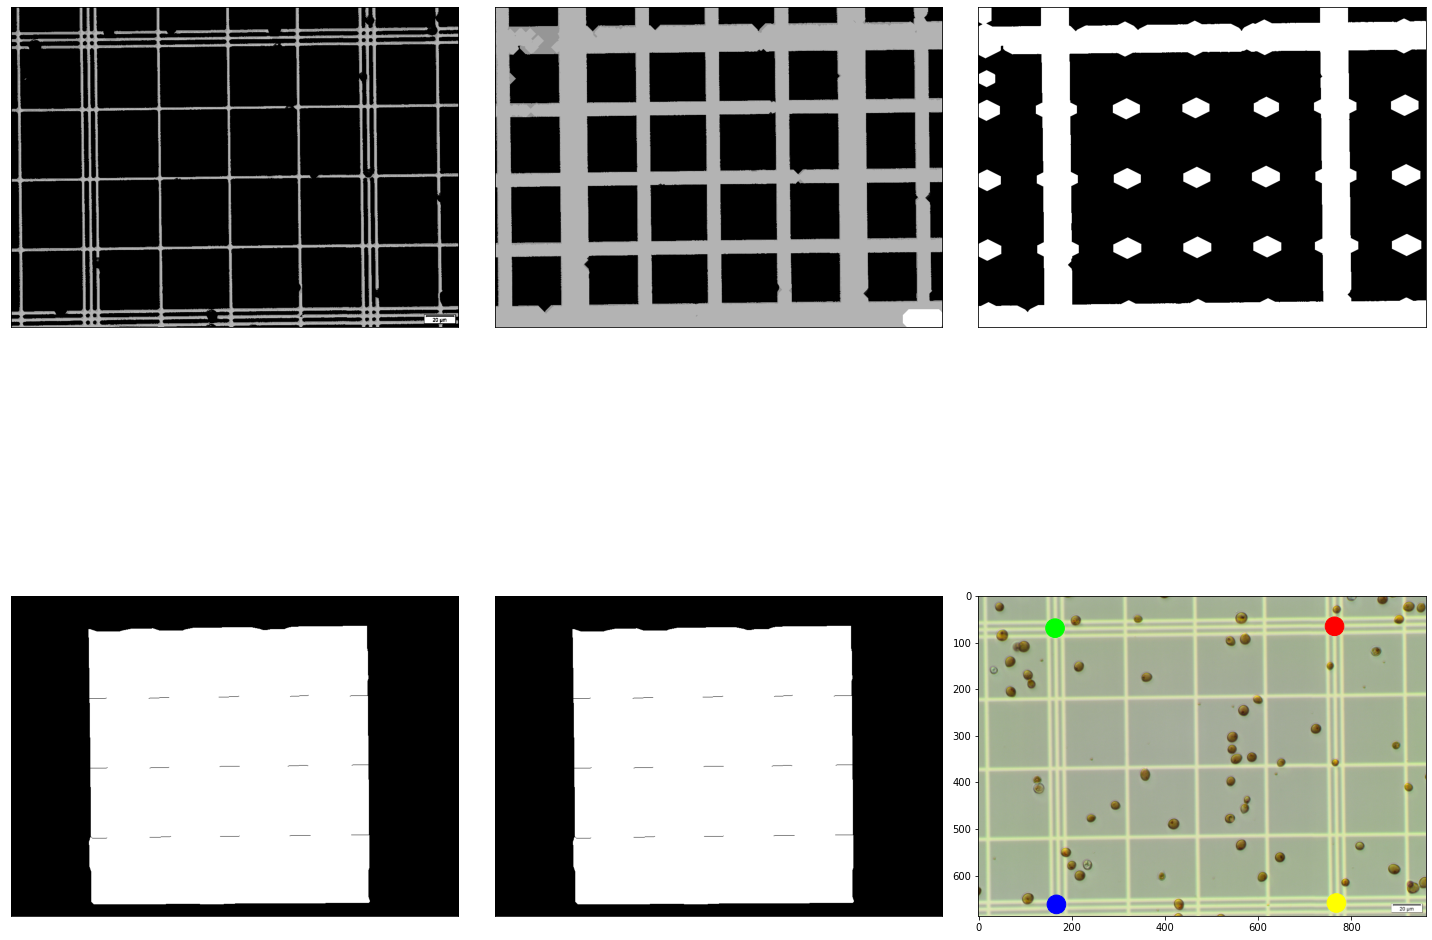

In [ ]:
img = downscale(img_grid[2][3], 0.25)
x = find_central_box(img, True, scale_factor=0.25)
plt.show()

In [ ]:
stitcher = _Stitcher(img_grid, 1)

Created stitcher with grid size (5, 5)


Finding corners of image (0, 0)... done!
Finding corners of image (0, 1)... done!
Finding corners of image (0, 2)... done!
Finding corners of image (0, 3)... done!
Finding corners of image (0, 4)... done!
Finding corners of image (1, 0)... done!
Finding corners of image (1, 1)... done!
Finding corners of image (1, 2)... done!
Finding corners of image (1, 3)... done!
Finding corners of image (1, 4)... done!
Finding corners of image (2, 0)... done!
Finding corners of image (2, 1)... done!
Finding corners of image (2, 2)... done!
Finding corners of image (2, 3)... done!
Finding corners of image (2, 4)... done!
Finding corners of image (3, 0)... done!
Finding corners of image (3, 1)... done!
Finding corners of image (3, 2)... done!
Finding corners of image (3, 3)... done!
Finding corners of image (3, 4)... done!
Finding corners of image (4, 0)... done!
Finding corners of image (4, 1)... done!
Finding corners of image (4, 2)... done!
Finding corners of image (4, 3)... done!
Finding corners 

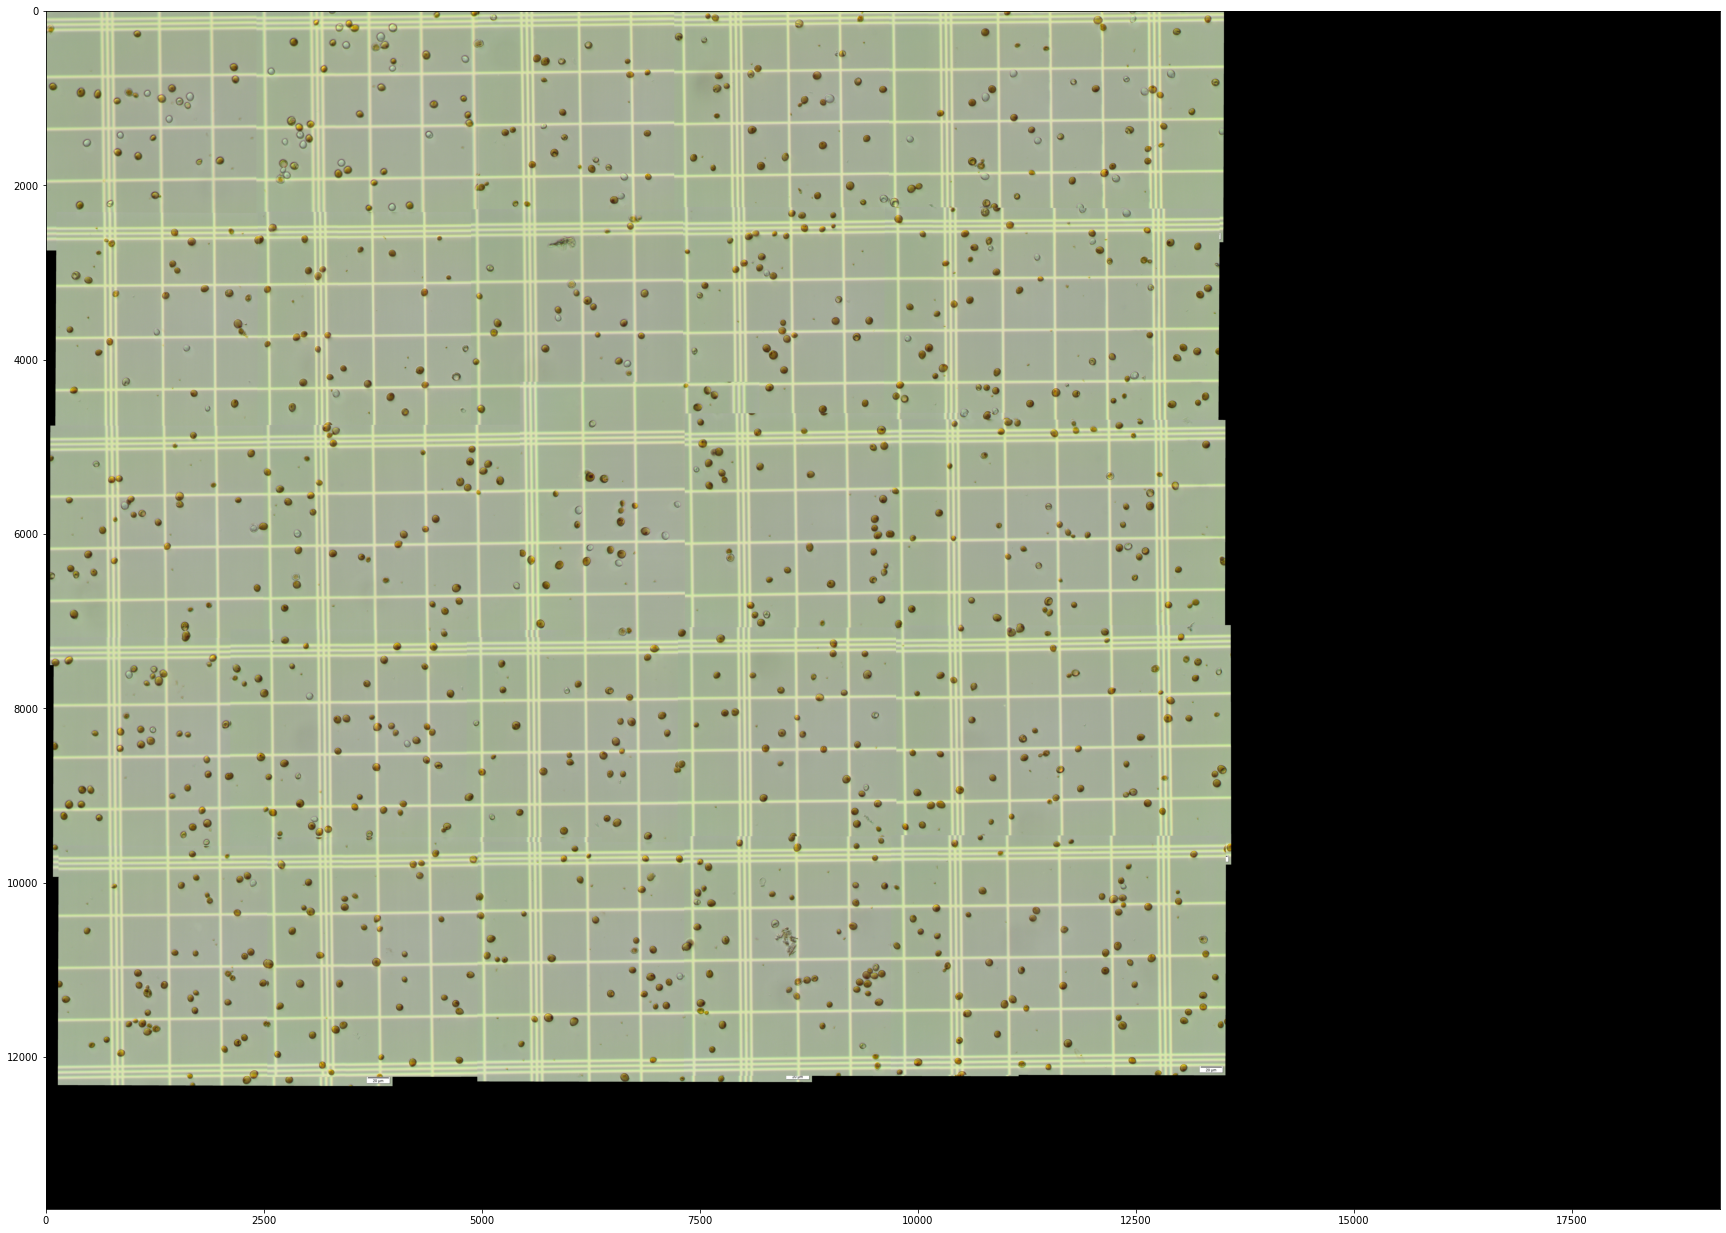

In [ ]:
output = stitcher.stitch()
plt.figure(figsize=(30,30))
plt.imshow(output)